https://twitter.com/charliemansell/status/1257068455645392896

What's up with Scotland?

In [167]:
dataset_name = "W19_comb"
df_list = [ "BES_Panel" , "BES_reduced_with_na"]

In [172]:
%%time
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

%matplotlib inline

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

sns.set();
sns.set_palette("colorblind")

from IPython.display import display, display_html, HTML
from IPython.core.debugger import set_trace
# plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews import opts

encoding = "ISO-8859-1"

# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()

global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_pickle(data_subfolder + dataset_filename.replace('.dta','.zip'),compression='zip')
    else:
        globals()[df]  = pd.read_pickle(data_subfolder + df + '.zip',compression='zip' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

# get full set of inferred "cross wave" auth-lib/left-right values and ages
# pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_valuesW19"+".csv")
pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )
pan_dataset_votes = pd.read_pickle(BES_small_data_files + "pan_dataset_votes"+".zip", compression='zip')

Toggle code

Wall time: 4min 52s


In [194]:
def weighted_qcut(values, weights, q, **kwargs):
    if is_integer(q):
        quantiles = np.linspace(0, 1, q + 1)
    else:
        quantiles = q
    #order = weights[values.argsort()].cumsum()
    order = weights[weights.index[values.argsort()]].cumsum()
    bins = pd.cut(order / order.iloc[-1], quantiles, **kwargs)
    return bins.sort_index()

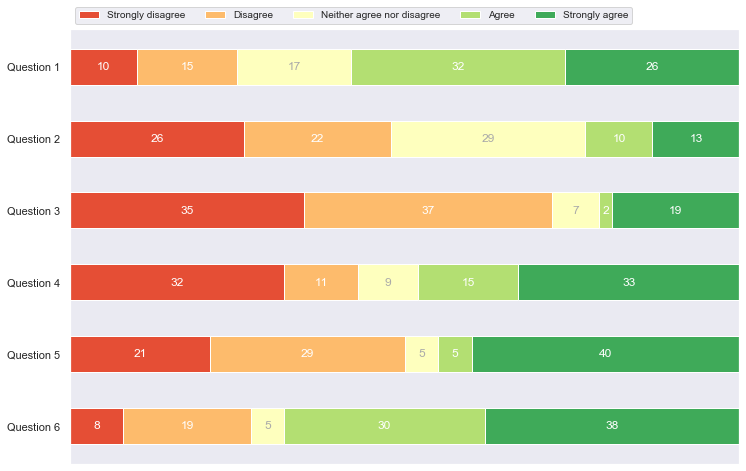

In [116]:

category_names = ['Strongly disagree', 'Disagree',
                  'Neither agree nor disagree', 'Agree', 'Strongly agree']
results = {
    'Question 1': [10, 15, 17, 32, 26],
    'Question 2': [26, 22, 29, 10, 13],
    'Question 3': [35, 37, 7, 2, 19],
    'Question 4': [32, 11, 9, 15, 33],
    'Question 5': [21, 29, 5, 5, 40],
    'Question 6': [8, 19, 5, 30, 38]
}


def survey(results, category_names, fig_size=(12,8),legend_col_max=5):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=fig_size)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=min(len(category_names),legend_col_max), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax

category_names = ['Strongly disagree', 'Disagree',
                  'Neither agree nor disagree', 'Agree', 'Strongly agree']
results = {
    'Question 1': [10, 15, 17, 32, 26],
    'Question 2': [26, 22, 29, 10, 13],
    'Question 3': [35, 37, 7, 2, 19],
    'Question 4': [32, 11, 9, 15, 33],
    'Question 5': [21, 29, 5, 5, 40],
    'Question 6': [8, 19, 5, 30, 38]
}

survey(results, category_names)
plt.show()


In [89]:
pan_dataset_allr_values.columns

Index(['Economic: Left(0) <-> Right(200){uniform}',
       'Social: Liberalism(0) <-> Conservatism(200){uniform}',
       'Economic: Left <-> Right{gaussian-ish}',
       'Social: Liberalism <-> Conservatism{gaussian-ish}',
       'Economic: Left <-> Right{gaussian-ish}completish',
       'Economic: Left <-> Right{gaussian-ish}complete',
       'Social: Liberalism <-> Conservatism{gaussian-ish}completish',
       'Social: Liberalism <-> Conservatism{gaussian-ish}complete'],
      dtype='object')

In [181]:
lr_col = pan_dataset_allr_values.columns[5]
al_col = pan_dataset_allr_values.columns[7]

In [226]:
mask = BES_Panel["gorW19"].notnull() & BES_Panel["wave19"] & BES_Panel["wt_new_W19_result"].notnull()

mask = mask & ~(pan_dataset_allr_values[al_col][mask].isnull()|pan_dataset_allr_values[lr_col][mask].isnull())
mask.sum()

32072

In [183]:
# mask = BES_Panel["gorW19"].notnull() & BES_Panel["wave19"] & BES_Panel[""]


# match(BES_Panel,"wt_new")

In [184]:
# pan_dataset_allr_values[al_col][mask].isnull().sum()

In [188]:
# pan_dataset_allr_values[lr_col][mask].isnull().sum()
pan_dataset_allr_values

,Economic: Left(0) <-> Right(200){uniform},Social: Liberalism(0) <-> Conservatism(200){uniform},Economic: Left <-> Right{gaussian-ish},Social: Liberalism <-> Conservatism{gaussian-ish},Economic: Left <-> Right{gaussian-ish}completish,Economic: Left <-> Right{gaussian-ish}complete,Social: Liberalism <-> Conservatism{gaussian-ish}completish,Social: Liberalism <-> Conservatism{gaussian-ish}complete
id,,,,,,,,
1,6.0,183.0,-1.913311,1.379564,-1.913311,-1.913311,1.379564,1.379564
2,195.0,54.0,1.929016,-0.648342,1.929016,1.929016,-0.648342,-0.648342
3,74.0,116.0,-0.313073,0.242132,-0.313073,-0.313073,0.242132,0.242132
4,149.0,132.0,0.643054,0.470176,0.643054,0.643054,0.470176,0.470176
5,169.0,99.0,1.004469,0.012041,1.004469,1.004469,0.012041,0.012041
...,...,...,...,...,...,...,...,...
98447,118.0,57.0,0.217387,-0.585382,0.217387,0.217387,-0.585382,-0.585382
98448,159.0,23.0,0.791833,-1.276719,0.791833,0.791833,-1.276719,-1.276719
98449,42.0,49.0,-0.789732,-0.721598,-0.789732,-0.789732,-0.721598,-0.721598


In [193]:
df

<bound method Series.sort_index of id
2510     (0.0, 0.2]
22512    (0.0, 0.2]
10295    (0.0, 0.2]
6255     (0.0, 0.2]
25796    (0.0, 0.2]
            ...    
790      (0.8, 1.0]
40568    (0.8, 1.0]
21071    (0.8, 1.0]
3592     (0.8, 1.0]
12338    (0.8, 1.0]
Name: wt_new_W19_result, Length: 32072, dtype: category
Categories (5, interval[float64]): [(0.0, 0.2] < (0.2, 0.4] < (0.4, 0.6] < (0.6, 0.8] < (0.8, 1.0]]>

In [195]:
df = weighted_qcut(pan_dataset_allr_values[lr_col][mask],BES_Panel["wt_new_W19_result"][mask],5 )
df.name = 'Economic Left-Right'

weighted_value_counts(df, BES_Panel["wt_new_W19_result"][mask])
# def weighted_qcut(values, weights, q, **kwargs):

,weighted_sample_size,raw_sample_size
Economic Left-Right,,
"(0.0, 0.2]",6379.020020,6994.0
"(0.4, 0.6]",6379.089844,5823.0
"(0.2, 0.4]",6379.979980,6162.0
"(0.6, 0.8]",6380.129883,6108.0
"(0.8, 1.0]",6380.459961,6985.0


In [196]:
%%time
df = weighted_qcut(pan_dataset_allr_values[lr_col][mask],BES_Panel["wt_new_W19_result"][mask],3 )
df.name = 'Economic Left-Right'
df = df.cat.rename_categories(["Left","Centre","Right"])
pd.crosstab(index=BES_Panel["gorW19"][mask],
             columns=df,
             values=BES_Panel["wt_new_W19_result"][mask],
             aggfunc=sum, normalize = 'index')*100

Wall time: 90 ms


Economic Left-Right,Left,Centre,Right
gorW19,,,
North East,36.317963,34.256557,29.425482
North West,37.371429,32.864773,29.763803
Yorkshire and The Humber,34.391945,34.346359,31.261688
East Midlands,31.487316,32.295650,36.217037
West Midlands,30.852150,32.684082,36.463768
East of England,28.979631,33.468788,37.551582
London,35.505669,35.363724,29.130602
South East,28.639013,33.243305,38.117680
South West,30.973497,33.424297,35.602207


In [197]:
%%time
lr = weighted_qcut(pan_dataset_allr_values[lr_col][mask],BES_Panel["wt_new_W19_result"][mask],3 )
lr.name = 'Economic Left-Right'
lr = lr.cat.rename_categories(["Left","Centre","Right"])
pd.crosstab(index=BES_Panel["gorW19"][mask],
             columns=lr,
             values=BES_Panel["wt_new_W19_result"][mask],
             aggfunc=sum, normalize = 'index')*100

Wall time: 86 ms


Economic Left-Right,Left,Centre,Right
gorW19,,,
North East,36.317963,34.256557,29.425482
North West,37.371429,32.864773,29.763803
Yorkshire and The Humber,34.391945,34.346359,31.261688
East Midlands,31.487316,32.295650,36.217037
West Midlands,30.852150,32.684082,36.463768
East of England,28.979631,33.468788,37.551582
London,35.505669,35.363724,29.130602
South East,28.639013,33.243305,38.117680
South West,30.973497,33.424297,35.602207


In [198]:
%%time
al = weighted_qcut(pan_dataset_allr_values[al_col][mask],BES_Panel["wt_new_W19_result"][mask],3 )
al.name = 'Social Liberal-Authoritarian'
al = al.cat.rename_categories(["Liberal","Moderate","Authoritarian"])
pd.crosstab(index=BES_Panel["gorW19"][mask],
             columns=al,
             values=BES_Panel["wt_new_W19_result"][mask],
             aggfunc=sum, normalize = 'index')*100

Wall time: 84 ms


Social Liberal-Authoritarian,Liberal,Moderate,Authoritarian
gorW19,,,
North East,26.710745,34.232288,39.056961
North West,32.557713,33.145485,34.296806
Yorkshire and The Humber,30.709209,33.862000,35.428795
East Midlands,30.064444,34.795273,35.140282
West Midlands,28.843557,34.867828,36.288612
East of England,31.224548,33.683144,35.092312
London,41.866856,31.961611,26.171532
South East,34.112083,32.585941,33.301971
South West,33.628292,32.937931,33.433769


In [201]:
df = pd.concat([al,lr],axis=1).apply(lambda x: x[lr.name]+"-"+x[al.name],axis=1).astype('category')
df = df.cat.reorder_categories([ 'Left-Liberal', 'Left-Moderate','Left-Authoritarian',
    'Centre-Liberal', 'Centre-Moderate','Centre-Authoritarian',
        'Right-Liberal', 'Right-Moderate','Right-Authoritarian',])

ct = pd.crosstab(index=BES_Panel["gorW19"][mask],
             columns=df,
             values=BES_Panel["wt_new_W19_result"][mask],
             aggfunc=sum, normalize = 'index')*100

In [202]:

ct

col_0,Left-Liberal,Left-Moderate,Left-Authoritarian,Centre-Liberal,Centre-Moderate,Centre-Authoritarian,Right-Liberal,Right-Moderate,Right-Authoritarian
gorW19,,,,,,,,,
North East,10.509969,9.754201,16.053797,8.651115,12.617218,12.988225,7.549664,11.860873,10.014944
North West,13.072577,9.621054,14.677795,9.776793,12.669455,10.418522,9.708339,10.854975,9.200486
Yorkshire and The Humber,11.528076,9.999683,12.864186,10.043207,11.352663,12.950489,9.137923,12.509648,9.614115
East Midlands,10.362107,9.369543,11.755662,9.383610,11.531682,11.380352,10.318724,13.894044,12.004267
West Midlands,9.359497,8.331907,13.160745,9.122823,12.365690,11.195564,10.361238,14.170228,11.932300
East of England,10.269939,6.986629,11.723063,9.300615,12.830507,11.337666,11.653993,13.866006,12.031584
London,17.307281,7.956327,10.242063,13.939291,13.430539,7.993895,10.620280,10.574744,7.935575
South East,10.581894,7.553778,10.503344,10.294895,12.616070,10.332339,13.235293,12.416098,12.466290
South West,11.041125,7.792078,12.140289,11.493610,12.095266,9.835417,11.093557,13.050586,11.458062


In [203]:
df.name = "pol_comp"
weighted_value_counts(df, BES_Panel["wt_new_W19_result"][mask],normalize=True,perc=True).sort_index()

,weighted_sample_percentage,raw_sample_size
pol_comp,,
Left-Liberal,12.33,4417.0
Left-Moderate,8.60,2686.0
Left-Authoritarian,12.40,4021.0
Centre-Liberal,10.37,3219.0
Centre-Moderate,12.49,3396.0
Centre-Authoritarian,10.47,3275.0
Right-Liberal,10.63,3365.0
Right-Moderate,12.24,3891.0
Right-Authoritarian,10.47,3802.0


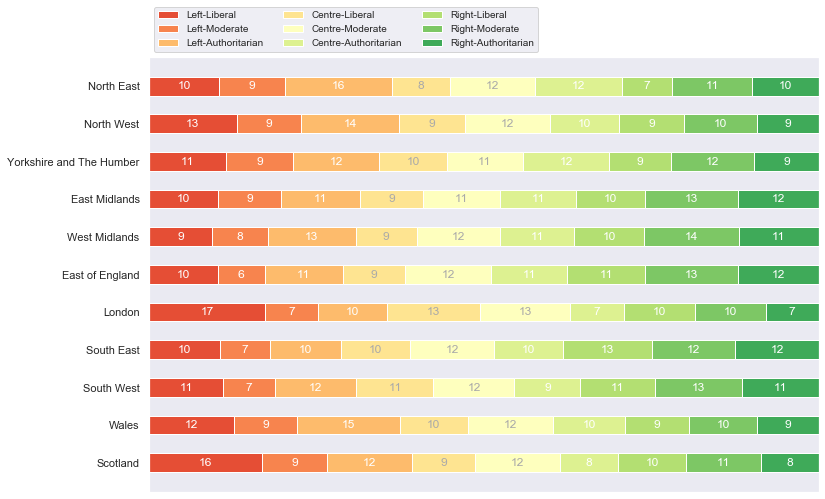

In [204]:
category_names = df.cat.categories
results = {k:list(v.values()) for k,v in ct.T.to_dict().items()}
survey(results, category_names,legend_col_max=3)
plt.show()

In [233]:
party_colour_dict = {"Lab":"red","LAB":"red",
                     "Con":'blue',"CON":'blue',"UKIP":"purple","LD":"orange",
                     "Grn":'green',"GRN":'green',
                     "BrexitParty":"cyan","BXP":'cyan',
                     "TIG":"pink","BNP":"magenta",
                     "SNP":'yellow',"PC":'olive',
                     "Remain":"yellow","REMAIN":'yellow',"Leave":"blue","LEAVE":'blue',
                     "Don't know":"grey","DK":'grey',
                     "Won't vote":"black","DNV":'black',"NON":'black',
                     "???":'lightgrey',"<18":'pink',"?":'darkgrey',"NULL":'black',
                     }

# party_list = list( BES_Panel[ ['profile_past_vote_2005','profile_past_vote_2010','profile_past_vote_2015' ] ].stack().unique() )
# party_list.append('I would not vote')
replace_dict = {'Labour Party':"LAB", 
 'United Kingdom Independence Party (UKIP)':"UKIP",
 'Labour':"LAB",
 'Conservative Party':"CON",
 'Conservative':"CON",
 'Liberal Democrats':"LD",
 'Did not vote':"DNV",
 'Scottish National Party':"SNP",
 'Scottish National Party (SNP)':"SNP",
 'British National Party (BNP)':"BNP",
 'Green Party':"GP",
 'Green':"GP",
 'Liberal Democrat':"LD",
 "Don't know":"DK",
 'Some other party':"OTH",
 'Veritas':"VER",
 'Plaid Cymru':"PC",
 'Other':"OTH",
 'Respect':"RES",
 'I would not vote':"DNV",
 "Brexit Party":"BXP",
 'Change UK- The Independent Group':"CUK",
 "Leave the EU":"LEAVE",
 "Stay/remain in the EU":"REMAIN",
 "Not Present":"NULL",
 "Ambiguous category":"?",
 "Unknown":"???",
 "Too Young To Vote":"<18",}



colourmap = {'LAB':'red', 'UKIP':'purple', 'CON':'blue', 'SNP':'yellow', 'BNP':'black', 'LD':'orange', 'DNV':'dimgray', 'DK':'lightgray', 'OTH':'brown', 'GP':'green',
       'VER':'pink', 'PC':'olive', 'RES':'peru', "BXP":'cyan',"CUK":'black','LEAVE':'blue','REMAIN':'yellow',
       "???":'grey',"<18":'pink',"?":'grey',"NULL":'black',     }
base_order = ['LAB','CON','DK','UKIP','LD','SNP','DNV','GP','PC','BNP','OTH','RES','VER']
lr_order   = ['GP','PC','LAB','SNP','DK','OTH','DNV','LD','CON','UKIP','BNP','RES','VER']
cmap = ['red','purple','blue','yellow','black','orange','grey','cyan','brown','green','pink','olive','peru']

In [205]:
al_scale = BES_Panel[search(BES_Panel,"al_scale").index].apply(lambda x:x.cat.codes.replace(-1,np.nan)).mean(axis=1)/20
lr_scale = BES_Panel[search(BES_Panel,"lr_scale").index].apply(lambda x:x.cat.codes.replace(-1,np.nan)).mean(axis=1)/20

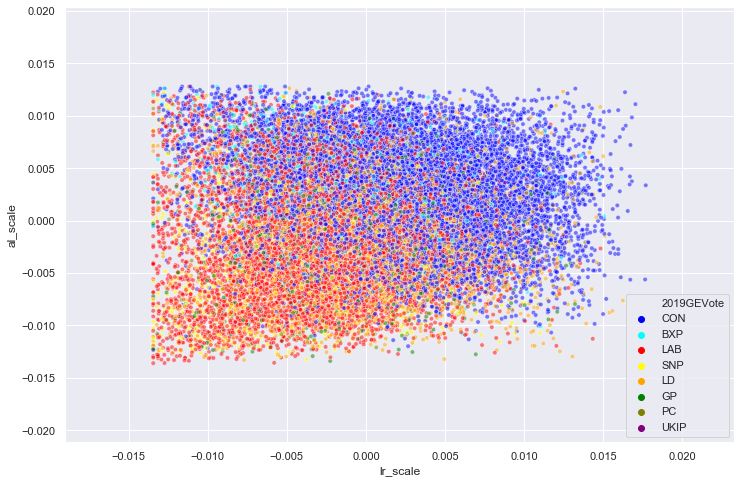

In [235]:
df=pd.DataFrame()
df["al_scale"] = pan_dataset_allr_values[pan_dataset_allr_values.columns[3]][mask]/200
df["lr_scale"] = pan_dataset_allr_values[pan_dataset_allr_values.columns[2]][mask]/200
df["2019GEVote"] = pan_dataset_votes["2019GEVote_complete"][mask]
drop_list = ["Unknown","Not Present","Did not vote","Don't know","Other"]
df = df[df["2019GEVote"].notnull() & df["2019GEVote"].apply(lambda x: x not in drop_list)]
df["2019GEVote"].cat.remove_unused_categories(inplace=True)
df["2019GEVote"] = df["2019GEVote"].replace(replace_dict)

plt.figure(figsize=(12,8));
sns.scatterplot(data=df,y='al_scale',x='lr_scale',hue ='2019GEVote', s=20, alpha=.5,palette=colourmap);

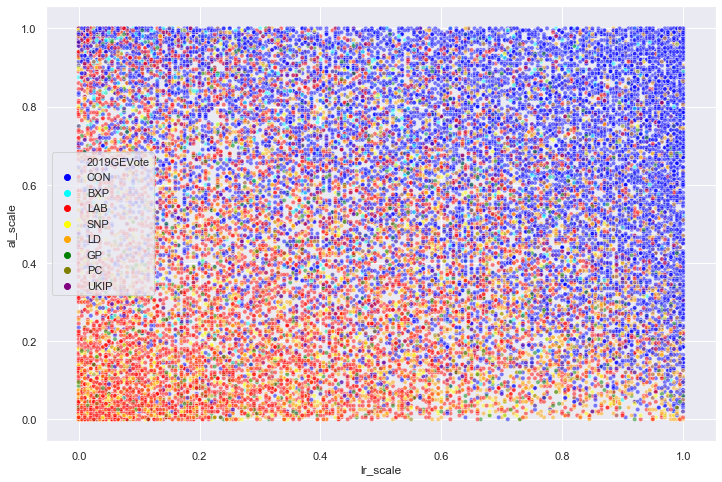

In [239]:
df=pd.DataFrame()
df["al_scale"] = pan_dataset_allr_values[pan_dataset_allr_values.columns[1]][mask]/200
df["lr_scale"] = pan_dataset_allr_values[pan_dataset_allr_values.columns[0]][mask]/200
df["2019GEVote"] = pan_dataset_votes["2019GEVote_complete"][mask]
drop_list = ["Unknown","Not Present","Did not vote","Don't know","Other"]
df = df[ df["2019GEVote"].notnull() & df["2019GEVote"].apply(lambda x: x not in drop_list) ]
df["2019GEVote"].cat.remove_unused_categories(inplace=True)
df["2019GEVote"] = df["2019GEVote"].replace(replace_dict)

plt.figure(figsize=(12,8));
sns.scatterplot(data=df,y='al_scale',x='lr_scale',hue ='2019GEVote', s=20, alpha=.5,palette=colourmap);

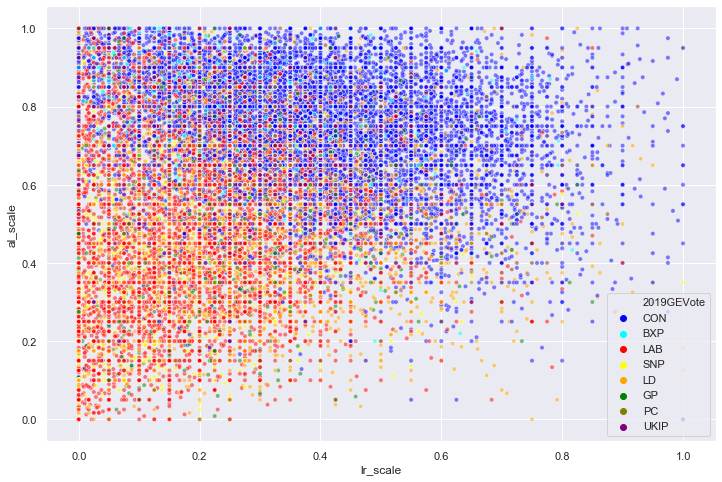

In [237]:
df=pd.DataFrame()
df["al_scale"] = al_scale
df["lr_scale"] = lr_scale
df["2019GEVote"] = pan_dataset_votes["2019GEVote_complete"]
drop_list = ["Unknown","Not Present","Did not vote","Don't know","Other"]
mask = df["2019GEVote"].notnull() & df["2019GEVote"].apply(lambda x: x not in drop_list)
df = df[mask]
df["2019GEVote"].cat.remove_unused_categories(inplace=True)
df["2019GEVote"] = df["2019GEVote"].replace(replace_dict)

plt.figure(figsize=(12,8));
sns.scatterplot(data=df,y='al_scale',x='lr_scale',hue ='2019GEVote', s=20, alpha=.5,palette=colourmap);

In [190]:
def weighted_qcut(values, weights, q, **kwargs):
    if is_integer(q):
        quantiles = np.linspace(0, 1, q + 1)
    else:
        quantiles = q
    #order = weights[values.argsort()].cumsum()
    order = weights[weights.index[values.argsort()]].cumsum()
    bins = pd.cut(order / order.iloc[-1], quantiles, **kwargs)
    return bins.sort_index

In [247]:
pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')

In [248]:
pan_dataset_ages.dtypes

id                                     int32
Age_at_W1                            float64
Age_at_W1_rounded                       int8
Age_at_W7                            float64
Age_at_W8                            float64
Age_at_W9                            float64
Age_at_W11                           float64
Age_at_W12                           float64
Age_at_W13                           float64
Age_at_W14                           float64
Age_at_W15                           float64
Age_at_W16                           float64
Age_at_W17                           float64
Age_at_W18                           float64
Age_at_W19                           float64
standardAgeGroup_at_W1              category
equalisedAgeGroup_at_W1             category
equalisedAgeGroup_at_W1_detailed    category
equalLengthAgeGroup_at_W1           category
rough_predictions                    float32
Age_at_W1_missing_values             float64
dtype: object

In [252]:
pan_dataset_ages = pan_dataset_ages.set_index('id').sort_index()

In [253]:
ct = pd.crosstab(index=BES_Panel["gorW19"][mask],
             columns=pan_dataset_ages["equalisedAgeGroup_at_W1_detailed"][mask],
             values=BES_Panel["wt_new_W19_result"][mask],
             aggfunc=sum, normalize = 'index')*100

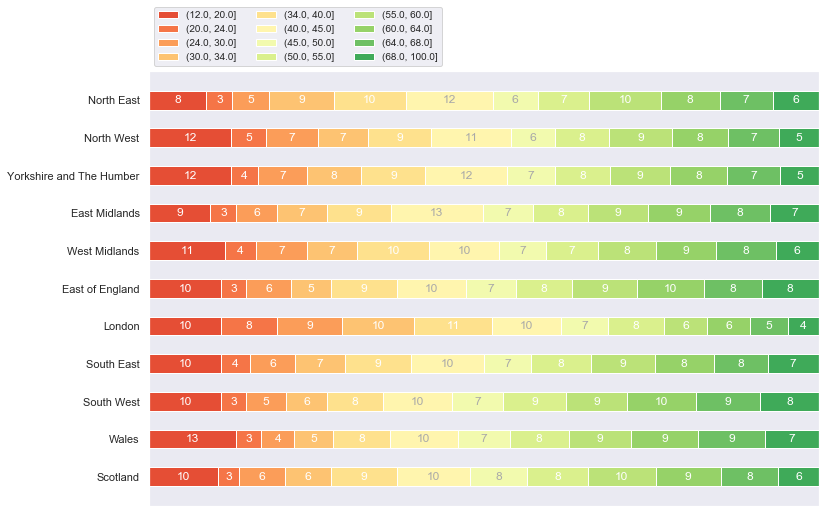

In [256]:
category_names = pan_dataset_ages["equalisedAgeGroup_at_W1_detailed"].cat.categories
results = {k:list(v.values()) for k,v in ct.T.to_dict().items()}
survey(results, category_names,legend_col_max=3)
plt.show()

In [285]:
col_sums = BES_reduced_with_na[mask].notnull().sum()

In [289]:
%%time

gor_means = BES_reduced_with_na[BES_reduced_with_na.columns[col_sums>1000]][mask].astype('float32').groupby(BES_Panel["gorW19"][mask]).mean()

Wall time: 46.1 s


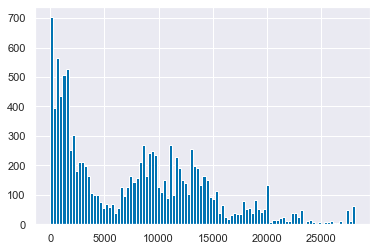

In [288]:
col_sums.hist(bins=100)

In [290]:
gor_val_means = pan_dataset_allr_values[[lr_col,al_col]][mask].astype('float32').groupby(BES_Panel["gorW19"][mask]).mean()

In [291]:
%%time
lr_corrs = gor_means.corrwith(gor_val_means["Economic: Left <-> Right{gaussian-ish}complete"])

Wall time: 11.5 s


In [292]:
df

,Economic: Left <-> Right{gaussian-ish}complete,Social: Liberalism <-> Conservatism{gaussian-ish}complete,turnoutUKGeneralW1__Very likely that I will vote,turnoutUKGeneralW2__Very likely that I will vote,turnoutUKGeneralW3__Very likely that I will vote,turnoutUKGeneralW4__Very likely that I will vote,turnoutUKGeneralW5__Very likely that I will vote,turnoutUKGeneralW7__Very likely that I will vote,turnoutUKGeneralW8__Very likely that I will vote,turnoutUKGeneralW9__Very likely that I will vote,...,conPriorities2_schoolW4_Yes,conPriorities2_nhsW4_Yes,conPriorities2_costLiveW4_Yes,devoResponsibleWalesJusticeW2_The UK Parliament,conPriorities2_immigW4_Yes,conPriorities2_crimeW4_Yes,sharedContentOnline_1W5_Yes,partySiteOthW5_Yes,euCitizenW1_Yes,conPriorities2_natsecW4_Yes
gorW19,,,,,,,,,,,,,,,,,,,,,
North East,-0.147327,0.255665,3.580882,3.663121,3.692833,3.649171,3.706897,3.772522,3.753906,3.799213,...,0.313953,0.244186,0.255814,NaN,0.337209,0.360465,0.123894,0.037037,0.010714,0.377358
North West,-0.103072,0.170741,3.607143,3.688503,3.698595,3.720430,3.743073,3.752974,3.788863,3.799513,...,0.262376,0.257426,0.232673,0.666667,0.371287,0.257426,0.149091,0.060870,0.021563,0.350000
Yorkshire and The Humber,-0.043698,0.168604,3.600969,3.661882,3.668750,3.702564,3.735683,3.769068,3.773023,3.818269,...,0.292135,0.264045,0.252809,0.666667,0.376404,0.308989,0.124736,0.081633,0.034591,0.405660
East Midlands,0.102818,0.146607,3.634546,3.701658,3.711434,3.756469,3.814236,3.821429,3.813747,3.815490,...,0.435897,0.416667,0.352564,0.600000,0.410256,0.346154,0.156716,0.056818,0.027125,0.514286
West Midlands,0.034829,0.187542,3.637523,3.709156,3.712727,3.751471,3.818937,3.766265,3.775711,3.804688,...,0.335366,0.335366,0.353659,1.000000,0.384146,0.323171,0.146572,0.080460,0.025135,0.410526
East of England,0.126738,0.152742,3.672083,3.740057,3.713267,3.733900,3.784741,3.820305,3.817708,3.845943,...,0.348066,0.364641,0.337017,1.000000,0.359116,0.364641,0.101594,0.051020,0.028736,0.396313
London,-0.011226,-0.223427,3.699519,3.788235,3.765816,3.756944,3.798441,3.829864,3.818775,3.822374,...,0.295775,0.291080,0.286385,1.000000,0.483568,0.413146,0.158909,0.062147,0.061844,0.496032
South East,0.178592,0.079625,3.696714,3.779221,3.748113,3.746032,3.782374,3.804521,3.802737,3.825359,...,0.353791,0.368231,0.328520,0.700000,0.480144,0.382671,0.126632,0.038251,0.030556,0.467085
South West,0.100208,0.100863,3.687943,3.755994,3.759722,3.780320,3.817232,3.801541,3.811212,3.829060,...,0.353591,0.359116,0.314917,0.700000,0.464088,0.375691,0.112339,0.094828,0.034868,0.476415


In [293]:
df = pd.concat([gor_val_means,gor_means],axis=1)

In [281]:
df[pattern]

gorW19
North East                 -0.147327
North West                 -0.103072
Yorkshire and The Humber   -0.043698
East Midlands               0.102818
West Midlands               0.034829
East of England             0.126738
London                     -0.011226
South East                  0.178592
South West                  0.100208
Wales                      -0.070934
Scotland                   -0.174472
Name: Economic: Left <-> Right{gaussian-ish}complete, dtype: float32

In [294]:
%%time
# BES_reduced_with_na["trust_per_resp"] = trust_per_resp
pattern = "Economic: Left <-> Right{gaussian-ish}complete"
name = "Economic: Left <-> Right{gaussian-ish}complete"
corr_type = "spearman"
corr_df,corr_type = make_corr_summary(df, name, corr_type, pattern=pattern,min_sample_size=1)
display_corr(corr_df, name, corr_type, text_wrap_length=50)

,r,p,N
pcBrexPrefW18__Leave with no deal,1.000000,0.00,3
redistSelfW7__Government should be less concerned[...],1.000000,0.00,11
approveUKGovtW2__Strongly approve,0.990000,0.00,11
conGovTrustW5__ Would do a good job,0.980000,0.00,11
likeCameronW4__Strongly like,0.980000,0.00,11
generalElectionVoteW5_Conservative,0.980000,0.00,11
lr_scaleW13__Right,0.980000,0.00,11
mpPartyW4_Conservative,0.980000,0.00,11
immigLDW11__Allow many more,0.980000,0.00,11
changeImmigLabW4__Getting a lot higher,0.980000,0.00,11


Wall time: 35.4 s


In [306]:


%%time
# BES_reduced_with_na["trust_per_resp"] = trust_per_resp
pattern = "Economic: Left <-> Right{gaussian-ish}complete"
name = "Economic: Left <-> Right{gaussian-ish}complete"
corr_type = "spearman"
corr_df,corr_type = make_corr_summary(df[list(gor_val_means.columns) + list(match(BES_reduced_with_na,demog_var).index)],
                                      name, corr_type, pattern=pattern,min_sample_size=1)
display_corr(corr_df, name, corr_type, text_wrap_length=50)

,r,p,N
gorW10_East of England,0.760000,0.01,11
profile_house_tenure_Own (part-own) through shared[...],0.740000,0.01,11
allSourceIncome_8W11_Yes,0.740000,0.01,11
profile_work_typeW7W10_Clerical/junior[...],0.720000,0.01,11
motherCountryBornW8_EU: pre-2004,0.710000,0.01,11
educationW8W9W10_Scottish Higher Certificate,-0.710000,0.01,11
educationW8W9W10_University diploma,-0.860000,0.00,11
,r,p,N
educationW8W9W10_University diploma,-0.860000,0.00,11
educationW8W9W10_Scottish Higher Certificate,-0.710000,0.01,11


Wall time: 1.63 s


In [307]:
df[list(gor_val_means.columns) + list(match(BES_reduced_with_na,demog_var).index)]

,Economic: Left <-> Right{gaussian-ish}complete,Social: Liberalism <-> Conservatism{gaussian-ish}complete,"anyUniW10__Yes, I graduated from higher education",edlevelW8W9W10__Postgrad,Age,profile_socgradeW8__E,profile_education_age__Still at school/Full time student,"profile_gross_household__£150,000 and over","profile_gross_personal__£100,000 and over",profile_household_size__8 or more,...,livedAbroadW8_Yes,friendsEUW8_Yes,parentsForeignW8_Yes,gender_Female,neverPrivSchlW1_W4W7W9_W12W14W15_Yes,privScndSchlW1_W4W7W9_W12W14W15_Yes,privPrimSchlW1_W4W7W9_W12W14W15_Yes,noDependentsInHouseW6_W14_Yes,preschoolKidsInHouseW6_W14_Yes,sickElderlyInHouseW6_W14_Yes
gorW19,,,,,,,,,,,,,,,,,,,,,
North East,-0.147327,0.255665,1.389299,2.886792,53.418423,2.403475,1.966667,4.982005,3.403990,1.352713,...,0.179487,0.335065,0.064103,0.512013,0.874580,0.096305,0.047032,0.726835,0.068592,0.095066
North West,-0.103072,0.170741,1.607704,2.984159,52.605293,2.271923,2.219551,5.275210,3.530257,1.444180,...,0.179462,0.402650,0.093906,0.524749,0.867097,0.108906,0.049377,0.734673,0.054774,0.097487
Yorkshire and The Humber,-0.043698,0.168604,1.574331,3.042056,51.962093,2.247681,2.198682,5.396297,3.634058,1.338290,...,0.172161,0.386534,0.084146,0.538305,0.871838,0.106802,0.050028,0.750000,0.051559,0.083933
East Midlands,0.102818,0.146607,1.488739,2.940850,53.279846,2.249722,2.110989,5.372294,3.753210,1.409389,...,0.183499,0.470845,0.073969,0.526049,0.863490,0.107534,0.072762,0.748271,0.056017,0.085062
West Midlands,0.034829,0.187542,1.556139,2.930443,52.479607,2.226229,2.282678,5.487638,3.839050,1.340064,...,0.162791,0.419580,0.124317,0.518083,0.875080,0.095602,0.062460,0.747606,0.047880,0.102599
East of England,0.126738,0.152742,1.372988,2.872727,53.416767,2.259516,2.127511,5.829837,4.046067,1.420642,...,0.179750,0.474596,0.097727,0.549459,0.830403,0.130300,0.076525,0.746800,0.060100,0.095715
London,-0.011226,-0.223427,1.827055,3.384134,48.999405,1.981331,2.859288,6.771798,4.800000,1.378357,...,0.288205,0.677182,0.251540,0.500544,0.789660,0.169792,0.114546,0.797230,0.052632,0.060388
South East,0.178592,0.079625,1.636737,3.077404,52.592037,2.077055,2.363897,6.272863,4.353241,1.364524,...,0.225569,0.537643,0.132450,0.538519,0.810913,0.145504,0.099863,0.767706,0.056514,0.077431
South West,0.100208,0.100863,1.600343,3.052558,54.253216,2.225726,2.268092,5.294557,3.516667,1.287469,...,0.223176,0.466814,0.107296,0.537076,0.800099,0.150543,0.110069,0.770414,0.049841,0.093849


In [299]:
demog_var = "travelEU|passportUK|passportOther|passportExpired|passportNever|livedAbroad|friendsEU|parentsForeign|motherCountryBorn|fatherCountryBorn"
demog_var = "|".join([demog_var,"ukCitizenW14|euCitizenW14|commonwealthCitizenW14|otherCitizenW14"])
demog_var = "|".join([demog_var,"gorW10|countryOfBirth[^W]|educationW8W9W10|profile_education_age[^W]|edlevelW8W9W10|anyUniW10"])
demog_var = "|".join([demog_var,"privPrimSchlW1_W4W7W9_W12W14W15|privScndSchlW1_W4W7W9_W12W14W15|neverPrivSchlW1_W4W7W9_W12W14W15|prvSchDKW1_W4W7W9_W12W14W15"])
demog_var = "|".join([demog_var,"marital|gender[^R]|disability[^W]|profile_ethnicity[^2W]|Age|profile_religion[^W]|profile_sexualityW10"])
demog_var = "|".join([demog_var,"profile_household_size[^W]|profile_household_children[^W]"])
demog_var = "|".join([demog_var,"preschoolKidsInHouseW6_W14|preschoolKidsInHouseW6_W14|sickElderlyInHouseW6_W14|noDependentsInHouseW6_W14"])
demog_var = "|".join([demog_var,"profile_gross_household[^W]|profile_gross_personal[^W]|profile_house_tenure[^W]|allSourceIncome_\d+W11"])
demog_var = "|".join([demog_var,"profile_work_typeW7W10|workingStatusW6_W12|ns_sec_analyticW6W7W8W9|profile_socgradeW8"])
demog_var

'travelEU|passportUK|passportOther|passportExpired|passportNever|livedAbroad|friendsEU|parentsForeign|motherCountryBorn|fatherCountryBorn|ukCitizenW14|euCitizenW14|commonwealthCitizenW14|otherCitizenW14|gorW10|countryOfBirth[^W]|educationW8W9W10|profile_education_age[^W]|edlevelW8W9W10|anyUniW10|privPrimSchlW1_W4W7W9_W12W14W15|privScndSchlW1_W4W7W9_W12W14W15|neverPrivSchlW1_W4W7W9_W12W14W15|prvSchDKW1_W4W7W9_W12W14W15|marital|gender[^R]|disability[^W]|profile_ethnicity[^2W]|Age|profile_religion[^W]|profile_sexualityW10|profile_household_size[^W]|profile_household_children[^W]|preschoolKidsInHouseW6_W14|preschoolKidsInHouseW6_W14|sickElderlyInHouseW6_W14|noDependentsInHouseW6_W14|profile_gross_household[^W]|profile_gross_personal[^W]|profile_house_tenure[^W]|allSourceIncome_\\d+W11|profile_work_typeW7W10|workingStatusW6_W12|ns_sec_analyticW6W7W8W9|profile_socgradeW8'

In [ ]:
list(match(BES_reduced_with_na,demog_var).index)

In [301]:
lr_corrs.loc[match(BES_reduced_with_na,demog_var).index].sort_values()

educationW8W9W10_University diploma                                                                                                               -0.830492
workingStatusW6_W12_Unemployed and looking for work                                                                                               -0.736713
allSourceIncome_6W11_Yes                                                                                                                          -0.594511
motherCountryBornW8_East Asia                                                                                                                     -0.579965
educationW8W9W10_Nursing qualification (eg SEN, SRN, SCM, RGN)                                                                                    -0.560963
                                                                                                                                                     ...   
workingStatusW6_W12_Working part time (8-29 hours a week)       

In [311]:
search(BES_Panel,"wt_new")

wt_new_W10           30237
wt_new_W11           30956
wt_new_W14           31063
wt_new_W15           30842
wt_new_W16           37959
wt_new_W1_W16         2427
wt_new_W18           37825
wt_new_W6W7          21081
wt_new_W2W6          23163
wt_new_W2W6W7        17076
wt_new_W9_W13        12562
wt_new_W12           34394
wt_new_W1_W11         6473
wt_new_W1_W12         5833
wt_new_W1_W13         5301
wt_new_W6_W11         9373
wt_new_W6_W12         8398
wt_new_W6_W13         7622
wt_new_W11_W13       21520
wt_new_W13W16        14647
wt_new_W13_result    31135
wt_new_W6W16          9587
wt_new_W2W16          8388
wt_new_W17           34366
wt_new_W13W17        15744
wt_new_W6W13W19       8743
wt_new_W9W19         13604
wt_new_W13_W19        5861
wt_new_W13W19        15811
wt_new_W16W19        21840
wt_new_W17W18W19     19000
wt_new_W19_result    32177
wt_new_W9            30036
wt_new_W8            33502
wt_new_W7            30895
wt_new_W6            30073
wt_new_W13W14        20393
w